# Emily.ipynb

## Quick test to apply hmm to Emily's shortcut data

### Import packages and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from IPython.display import display, clear_output

sys.path.insert(0, 'helpers')
sys.path.insert(0, 'C:/Users/etien/Dropbox/work/vdmlab/vdmlab')
sys.path.insert(0, '../vdmlab/emi_shortcut/')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import klabtools as klab
import seqtools as sq
import vdmlab as vdm
from load_data import get_pos, get_spikes, get_lfp
import info.r068d1 as info

import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1.5})
sns.set_style("white")

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


### Define helper function(s)

In [2]:
from mymap import Map

def extract_subsequences_from_binned_spikes(binned_spikes, bins):
    data = spikes.data.copy()
    boundaries = klab.get_continuous_segments(bins)
    
    binned = Map()
    binned['bin_width'] = binned_spikes.bin_width
    binned['data'] = binned_spikes.data[bins,:]
    binned['boundaries'] = boundaries
    binned['boundaries_fs'] = 1/binned_spikes.bin_width   
    binned['sequence_lengths'] = (boundaries[:,1] - boundaries[:,0] + 1).flatten()
    
    return binned

### Load data

In [3]:
spikes = get_spikes(info.spike_mat)
pos = get_pos(info.pos_mat, info.pxl_to_cm) # what should pixel-to-cm be?

(0.0, 100.0, 0.0, 70.0)

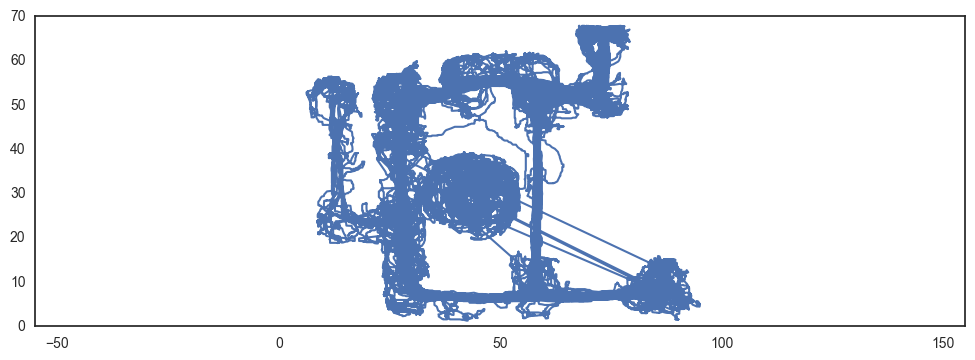

In [4]:
plt.plot(pos.x, pos.y)
plt.axis('equal')

(0, 200)

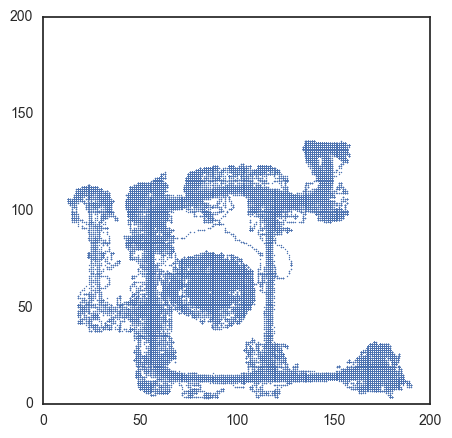

In [5]:
# digitize pixels
nbins = 200
bins = np.linspace(0, 100, nbins)
Hx = np.digitize(pos.x, bins=bins)
Hy = np.digitize(pos.y, bins=bins)

fig = plt.figure(1, figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(Hx,Hy,'o', markersize=1)
ax.axis('equal')
ax.set_xlim([0, nbins])
ax.set_ylim([0, nbins])


In [6]:
spiketrain = []

for unit, train in enumerate(spikes):
    spiketrain.append(train.time)

In [7]:
# since I expect sample numbers starting from 0 for spike trains, I can simply subtract an offset off of a time-specified spike train, and bin that instead.

firstSpikeTime = spiketrain[0].max()
for train in spiketrain:
    firstSpikeTime = min(firstSpikeTime, train.min())
    
print(firstSpikeTime)

for unit, train in enumerate(spiketrain):
    spiketrain[unit] = train - firstSpikeTime

21295.6546


In [8]:
# get position on the same timescale as the observations

pos.time = pos.time - firstSpikeTime # crude, but works; also, first pos time happens after first spike

fs = 1
ds = 0.125
num_bins = int(np.ceil(np.max([np.max(x) for x in spiketrain if len(x)>0])/fs/ds))
total_time = num_bins*ds # total time in seconds

time = np.linspace(0,total_time, num_bins)
interpposx = np.interp(time, pos.time, pos.x)
interpposy = np.interp(time, pos.time, pos.y)

In [9]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spiketrain,  ds=ds, fs=1, verbose=True)

binning data into 64776 x 125.0 ms temporal bins...


In [10]:
## stack data for hmmlearn:
seq_stk = sq.data_stack(binned_spikes, verbose=True)

Only one sequence in data; so data is already in stacked format...


In [11]:
num_states = 45
myhmm2 = sq.hmm_train(seq_stk, num_states=num_states, n_iter=50, verbose=True)

         2    -1935159.0803     +133489.6049
         3    -1912864.8635      +22294.2168
         4    -1902997.2923       +9867.5712
         5    -1896802.9663       +6194.3260
         6    -1892174.9280       +4628.0383
         7    -1888918.6098       +3256.3182
         8    -1886596.7833       +2321.8266
         9    -1884731.6510       +1865.1323
        10    -1883112.6213       +1619.0297
        11    -1881684.8702       +1427.7511
        12    -1880347.5940       +1337.2762
        13    -1879120.6711       +1226.9229
        14    -1878246.1031        +874.5680
        15    -1877643.6009        +602.5022
        16    -1877158.5509        +485.0499
        17    -1876700.8556        +457.6953
        18    -1876186.4421        +514.4135
        19    -1875670.6580        +515.7841
        20    -1875214.7570        +455.9010
        21    -1874891.8314        +322.9256
        22    -1874626.3353        +265.4960
        23    -1874354.4661        +271.8693
        24

In [21]:
## 2D place field approximation

nbins = 100
xy00 = 0
xyLL = 100
bins = np.linspace(xy00, xyLL, nbins)

num_sequences = len(seq_stk.sequence_lengths)
num_states = myhmm2.n_components
state_pos2D = np.zeros((num_states, nbins, nbins)) # stack of 2D place fields

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(seq_stk.sequence_lengths).tolist());
    obs = seq_stk.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmm2.score_samples(obs)
    if num_sequences == 1:
        xx = interpposx
        yy = interpposy
    else:
        xx = interpposx[seq_stk.boundaries[seq_id,0]:seq_stk.boundaries[seq_id,1]+1]
        yy = interpposy[seq_stk.boundaries[seq_id,0]:seq_stk.boundaries[seq_id,1]+1]
    dxx = np.digitize(xx, bins) - 1 # spatial bin numbers
    dyy = np.digitize(yy, bins) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos2D[:,dxx[ii],dyy[ii]] += np.transpose(ppii) 


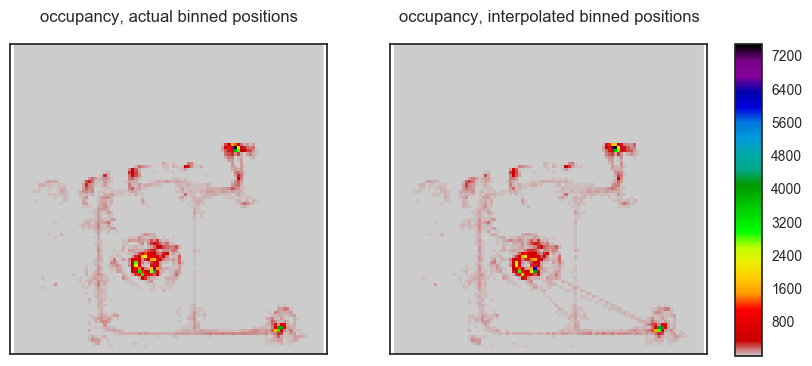

In [22]:
# compute occupancy
bins = np.linspace(xy00, xyLL, nbins+1)

H, _, _ = np.histogram2d(pos.x, pos.y, bins=bins)
# plt.matshow(H, cmap='PuRd')
# plt.title('occupancy')
H[H==0]=1

# normalize place fields
for ii, stateposfield in enumerate(state_pos2D):
        state_pos2D[ii,:,:] = stateposfield / H
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)

Hinterp, _, _ = np.histogram2d(interpposx, interpposy, bins=bins)
    
im = ax1.matshow(H[:,::-1].T, interpolation='none', cmap='spectral_r'); ax1.set_title('occupancy, actual binned positions'); ax1.set_xticklabels([]); ax1.set_yticklabels([])
ax2.matshow(Hinterp[:,::-1].T, interpolation='none', cmap='spectral_r'); ax2.set_title('occupancy, interpolated binned positions'); ax2.set_xticklabels([]); ax2.set_yticklabels([])
# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.93, 0.12, 0.03, 0.78])
fig.colorbar(im, cax=cax)

**Remark:** Is the discrepancy in the occupancies between the actual and interpolated positions due to an experimental artifact, where the rat is transported from a reward location to the pedestal? If there is a time gap, the interpolant would just move the rat slowly between the reward location and the sleep pedestal, so this would make complete sense, and the neural data would stil be correctly aligned to the rest of the position data.


[]

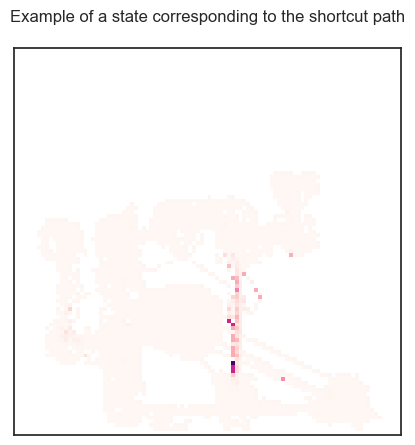

In [32]:
fig = plt.figure(1, figsize=(5, 5))
ax = fig.add_subplot(111)

state = 14
state_pos2D[state_pos2D==0] = np.nan
im = ax.matshow(state_pos2D[state,:,::-1].T,interpolation='none', cmap='RdPu',  )
# fig.colorbar(im)
ax.set_title('Example of a state corresponding to the shortcut path'); ax.set_xticklabels([]); ax.set_yticklabels([])

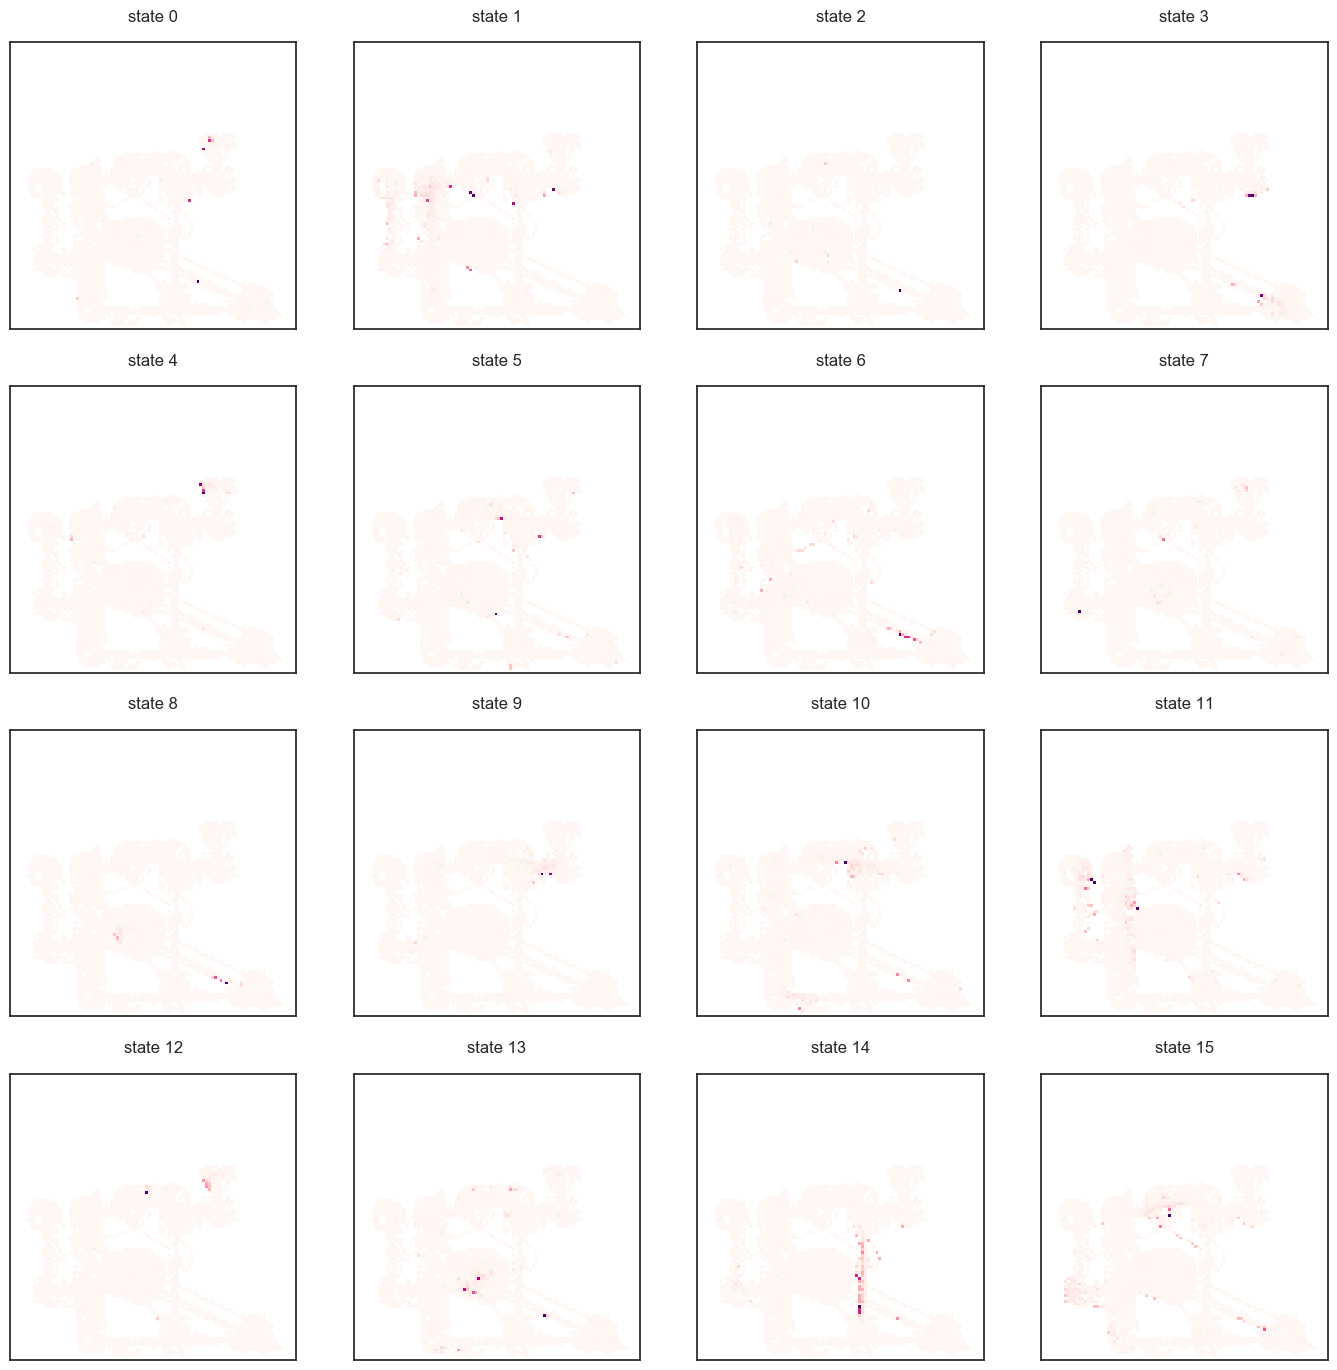

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(17, 17), sharex=True, sharey=True)
axes = [item for sublist in axes for item in sublist]

for state, ax in enumerate(axes):
    ax.matshow(state_pos2D[state,:,::-1].T, cmap='RdPu')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('state ' + str(state))